# Analysis for salmon trap data in the Dungenesss River from 2005-2014
### Description of data:
Data is stored in MS Excel files with one sheet per year. For 2005, the counts for both wild and hatchery are together with an additional column for wild fish. For all other years, counts for wild and hatchery fish are separate.



In [1]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [106]:
#read file
df_2005 = pd.read_excel(
   io="C:/Users/maria/OneDrive/Documents/data/pied_piper/Dungeness smolt trap 2005 - 2014.xlsx",
   sheet_name ='2005',
    header = [3,4]
)
df_2005.head()
#columns = list(df)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/maria/OneDrive/Documents/data/pied_piper/Dungeness smolt trap 2005 - 2014.xlsx'

In [124]:
#if using linux machine:
df_2005 = pd.read_excel(
   io="/home/maria/Documents/data/pied_piper/Dungeness smolt trap 2005 - 2014.xlsx",
   sheet_name ='2005',
    header = [3,4]
)
df_2005.head()
df_2005.columns

MultiIndex([(                         'Unnamed: 0_level_0',  'Down'),
            (                         'Unnamed: 1_level_0',    'Up'),
            (                         'Unnamed: 2_level_0',    'In'),
            (                         'Unnamed: 3_level_0',   'Out'),
            (                                 'Chinook 0+',      10),
            (                                 'Chinook 1+',      11),
            (                                       'Chum',      20),
            (                                    'Coho 0+',      40),
            (                                   'Coho 1+ ',      41),
            (                                       'Pink',      30),
            (                                    'Sockeye',      50),
            (                                 'Trout parr',      65),
            (                           'Steelhead smolts',      71),
            (                           'Cutthroat smolts',      61),
            (       

In [125]:
df_2005.columns
df_2005.rename(columns = {
    'Unnamed: 0_level_0':'Down',
    'Unnamed: 1_level_0':'Up',
    'Unnamed: 2_level_0':'In',
    'Unnamed: 3_level_0':'Out',
    'Coho 1+ ':'Coho 1+'
}, inplace = True)
# df_2005['Coho 1+ Wild']=np.nansum([df_2005['Coho 1+ UC mark Wild'],df_2005['Coho 1+ LC mark Wild']],axis = 0)
# df_2005['Coho 1+ Hatchery']=np.nansum([df_2005['Coho 1+ Hatchery ad-mark'],df_2005['Coho 1+ hatchery CWT not ad-marked']],axis = 0)
df_2005.columns
# df_2005['Coho 1+ Wild'] = df_2005.loc[: , ['Coho 1+ UC mark Wild', 'Coho 1+ LC mark Wild']].sum(axis=1)

# df_2005['Coho 1+ Hatchery'] = df_2005.loc[: , ['Coho 1+ Hatchery ad-mark', 'Coho 1+ hatchery CWT not ad-marked']].sum(axis=1)

df_2005['Coho 1+ UC mark Wild per hour'] = df_2005['Coho 1+ UC mark Wild'].div(df_2005['In'].values)
df_2005['Coho 1+ LC mark Wild per hour'] = df_2005['Coho 1+ LC mark Wild'].div(df_2005['In'].values)
df_2005['Coho 1+ Wild per hour'] = np.nansum([df_2005['Coho 1+ UC mark Wild per hour'],df_2005['Coho 1+ LC mark Wild per hour']], axis = 0)


df_2005['Coho 1+ Hatchery ad-mark per hour'] = df_2005['Coho 1+ Hatchery ad-mark'].div(df_2005['In'].values)
df_2005['Coho 1+ hatchery CWT not ad-marked per hour'] = df_2005['Coho 1+ hatchery CWT not ad-marked'].div(df_2005['In'].values)
df_2005['Coho 1+ Hatchery per hour'] = np.nansum([df_2005['Coho 1+ Hatchery ad-mark per hour'],df_2005['Coho 1+ hatchery CWT not ad-marked per hour']], axis = 0)



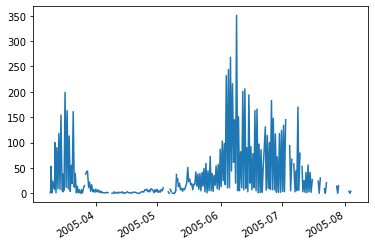

In [29]:
plt.plot(df['Down'], df['Chinook 0+'])
plt.gcf().autofmt_xdate()
plt.show()

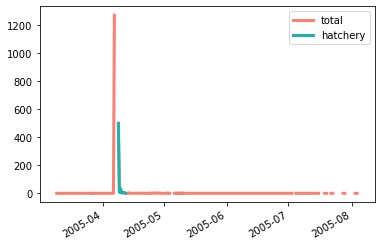

In [64]:
plt.plot(df['Down'], df['Chinook 1+'], linewidth = 3, label = 'total', color = 'black')
plt.plot(df['Down'], df['Chinook 1+ CWT hatchery'], linewidth = 3, label  = 'hatchery', color = 'lightseagreen')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

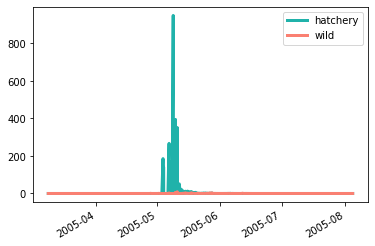

In [131]:
#plt.plot(df['Down'], df['Coho 1+'], linewidth = 3, label = 'total', color = 'black')
plt.plot(df_2005['Down'], df_2005['Coho 1+ Hatchery per hour'], linewidth = 3, label  = 'hatchery', color = 'lightseagreen')
plt.plot(df_2005['Down'], df_2005['Coho 1+ Wild per hour'], linewidth = 3, label = 'wild', color = 'salmon')

plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [127]:
n= 118
uc_wild = df_2005['Coho 1+ UC mark Wild'].iloc[n]
hours = df_2005['In'].iloc[n]
uc_wild_per_hour = df_2005['Coho 1+ UC mark Wild per hour'].iloc[n]





lc_wild = df_2005['Coho 1+ LC mark Wild'].iloc[n]
hours = df_2005['In'].iloc[n]
lc_wild_per_hour = df_2005['Coho 1+ LC mark Wild per hour'].iloc[n]
coho_wild_per_hour = df_2005['Coho 1+ Wild per hour'].iloc[n]

ad_hatchery = df_2005['Coho 1+ Hatchery ad-mark'].iloc[n]
ad_hatchery_per_hour = df_2005['Coho 1+ Hatchery ad-mark per hour'].iloc[n]
not_ad_hatchery = df_2005['Coho 1+ hatchery CWT not ad-marked'].iloc[n]
not_ad_hatchery_per_hour = df_2005['Coho 1+ hatchery CWT not ad-marked per hour'].iloc[n]
coho_hatchery_per_hour = df_2005['Coho 1+ Hatchery per hour'].iloc[n]

print(f"ad_hatchery: {ad_hatchery}")
print(f"hours: {hours}")
print(f"ad hatchery per hour: {ad_hatchery_per_hour}")
print(f"ad_hatchery: {not_ad_hatchery}")
print(f"ad hatchery per hour: {not_ad_hatchery_per_hour}")
print(f"coho hatchery: {coho_hatchery_per_hour}")



ad_hatchery: 41\13    1053.0
Name: 118, dtype: float64
hours: In    5.666667
Name: 118, dtype: float64
ad hatchery per hour: 185.8235294117647
ad_hatchery: 41\30   NaN
Name: 118, dtype: float64
ad hatchery per hour: nan
coho hatchery: 185.8235294117647


In [105]:
df_2005['test_col'] = df_2005['Coho 1+ UC mark Wild'].div(df_2005['In'].values)
df_2005['test_col'].iloc[168]

0.2517482517482518